In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.transforms import Affine2D
from typing import List, Optional, Tuple, Dict
import dataclasses
from main import TrackConfig, generate_track_boundaries, TrackVisualizer, LIDARReading, LIDARSimulator, CarController, CarKinematics, CarState
import time as ti
from scipy.stats import wasserstein_distance
import pygad

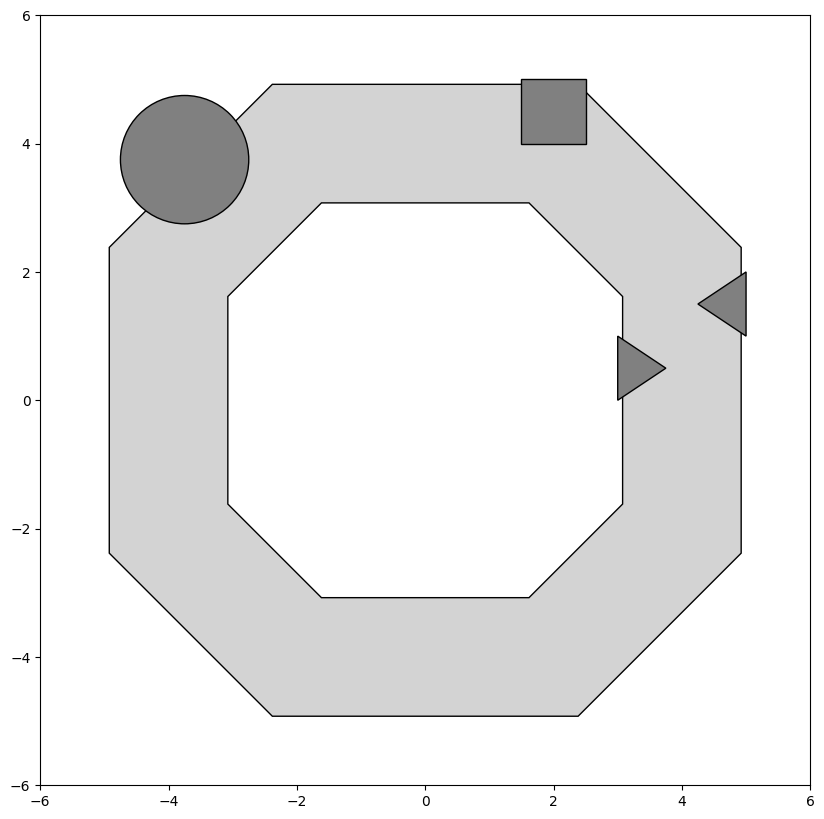

In [22]:
# Define centerline points for a larger, centered oval track 
centerline_points = [
    (-4, 2), 
    (-2, 4), 
    (2, 4),
    (4, 2), 
    (4, -2),
    (2, -4),
    (-2, -4),
    (-4, -2)
    ]
track_width = 2.0  # Increased track width for better visibility

# Generate track boundaries
inner_boundary, outer_boundary = generate_track_boundaries(centerline_points, track_width)

# Create track configuration with better distributed obstacles
track_config = TrackConfig(
    bounds=((-6, 6), (-6, 6)),
    obstacles = [
        ([-3.75, 3.75], 1, "circle"), 
        ([(1.5, 4), (1.5, 5), (2.5, 5), (2.5, 4), (1.5, 4)], 0, "polygon"),
        ([(5, 2), (5, 1), (4.25, 1.5)], 0, "polygon"), 
        ([(3, 1), (3, 0), (3.75, 0.5)], 0, "polygon")
    ],
    track_width=track_width,
    inner_boundary=inner_boundary,
    outer_boundary=outer_boundary
)

centerline_points = np.array(centerline_points)
xcoords = centerline_points[:,0]
ycoords = centerline_points[:,1]

# haha bruteforced an optimal path :clown:
optimal_path = [
    (-4, 0),
    (-4.35, 2.75),
    (-4.35, 4), 
    (-3, 4.35),
    (-1.25, 3.75),
    (3.5, 3.75), 
    (3.75, 3.25),
    (3.75, 1),
    (4.35, 0),
    (4.35, -2),
    (4, -3.5),
    (2, -4),
    (1, -4.35),
    (0, -4),
    (-1, -3.6),
    (-2, -4),
    (-3, -4.35),
    (-3.8, -4), 
    (-4, -3),
    (-4, 0)
]
optimal_path = np.array(optimal_path)
x_opt = optimal_path[:, 0]
y_opt = optimal_path[:, 1]

visualizer = TrackVisualizer(track_config)
# plt.plot(xcoords, ycoords)
#plt.plot(x_opt, y_opt)

In [35]:
# Initialize components with tuned parameters
car_length = 0.1
collisions = 0

######## PARAMETERS TO CHANGE ############
noise = 0.001
ray_noise = 0.03
angle_span = np.pi * 2/3    # 120 degree field of view
num_beams = 120
gap_threshold = 1
collision_threshold = 0.12
gap_threshold = 0.5
##########################################

lidar = LIDARSimulator(
    num_beams=num_beams,
    angle_span=angle_span,  
    max_range=5.0,
    car_length=car_length,
    car_width=0.1, 
    ray_std = ray_noise, 
    collision_threshold=collision_threshold
)
controller = CarController(
    gap_threshold=gap_threshold,
    num_beams=num_beams,
    angle_span=angle_span  # Match LIDAR's angle span
)
kinematics = CarKinematics(
    car_length=car_length,
    velocity=2,  # Reduced velocity for better control
    dt=0.05,
    x_std=noise,   # Reduced noise for smoother motion
    y_std=noise,
    theta_std=noise
)

# Initial car state - start at the beginning of the track
initial_heading = np.arctan2(
    centerline_points[1][1] - centerline_points[0][1],
    centerline_points[1][0] - centerline_points[0][0]
)
car_state = CarState(centerline_points[0][0], centerline_points[0][1], initial_heading)

In [36]:
end = 17       # arbitrary time
length = np.arange(0, end, kinematics.dt)

trajectory = [(car_state.x, car_state.y)]

start_time = ti.time()

    
for i in range(len(length)):
    # Get LIDAR readings
    lidar_reading = lidar.get_readings(car_state, track_config, collision_threshold)
    if lidar_reading.collisions:
        collisions += 1

    # Get steering decision
    steering_angle = controller.get_steering_angle(lidar_reading.distances)

    # Update car state
    car_state = kinematics.update_state(car_state, steering_angle)
    trajectory.append((car_state.x, car_state.y))

end_time = ti.time()
sim_time = end_time - start_time


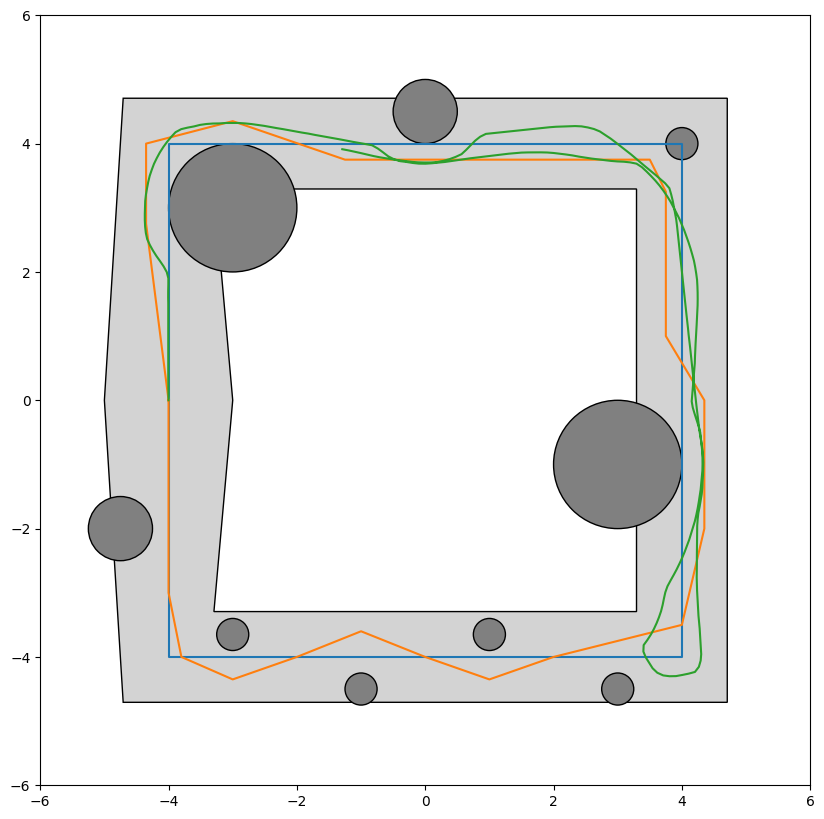

In [37]:
trajectory = np.array(trajectory)

visualizer = TrackVisualizer(track_config)
plt.plot(xcoords, ycoords)
plt.plot(x_opt, y_opt)
plt.plot(trajectory[:,0], trajectory[:, 1])

## GA starts here 

In [ ]:
# simulation

def simulation(angle_span, num_beams, gap_threshold):
    # Initialize components with tuned parameters
    car_length = 0.1
    collisions = 0

    ######## PARAMETERS TO CHANGE ############
    noise = 0.001
    ray_noise = 0.03
    angle_span = angle_span   #np.pi * 2/3 # = 120 degree field of view
    num_beams = num_beams      # 120
    gap_threshold = 0.25
    collision_threshold = 0.12
    gap_threshold = gap_threshold
    ##########################################

    lidar = LIDARSimulator(
        num_beams=num_beams,
        angle_span=angle_span,  
        max_range=5.0,
        car_length=car_length,
        car_width=0.1, 
        ray_std = ray_noise, 
        collision_threshold=collision_threshold
    )
    controller = CarController(
        gap_threshold=gap_threshold,
        num_beams=num_beams,
        angle_span=angle_span  # Match LIDAR's angle span
    )
    kinematics = CarKinematics(
        car_length=car_length,
        velocity=2,  # Reduced velocity for better control
        dt=0.05,
        x_std=noise,   # Reduced noise for smoother motion
        y_std=noise,
        theta_std=noise
    )

    # Initial car state - start at the beginning of the track
    initial_heading = np.arctan2(
        centerline_points[1][1] - centerline_points[0][1],
        centerline_points[1][0] - centerline_points[0][0]
    )
    car_state = CarState(centerline_points[0][0], centerline_points[0][1], initial_heading)

    end = 17       # arbitrary time
    length = np.arange(0, end, kinematics.dt)

    trajectory = [(car_state.x, car_state.y)]

        
    for i in range(len(length)):
        # Get LIDAR readings
        lidar_reading = lidar.get_readings(car_state, track_config, collision_threshold)
        if lidar_reading.collisions:
            collisions += 1

        # Get steering decision
        steering_angle = controller.get_steering_angle(lidar_reading.distances)

        # Update car state
        car_state = kinematics.update_state(car_state, steering_angle)
        trajectory.append((car_state.x, car_state.y))

    return np.array(trajectory), collisions


In [1]:
# Optimization using GA (pygad)

# fitness function, goal is to minimize emd
def fitness_func(ga_instance, solution, solution_idx):
    angle_span = int(solution[0])
    num_beams = int(solution[1])
    gap_threshold = int(solution[2])
    trajectory, collisions = simulation(angle_span, num_beams, gap_threshold)
    emd = wasserstein_distance(trajectory.flatten(), optimal_path.flatten())
    
    # GA aims to maximize fitness
    return [1 / emd, - collisions]

function_inputs = [np.pi * 2/3, 120, 1]

fitness_function = fitness_func

### GA parameters ##################
num_generations = 60
num_parents_mating = 5

sol_per_pop = 10
num_genes = len(function_inputs)

init_range_low = [np.pi * 1/18, 10, 0.5]  # Lower bound for angle_span (10 deg) and num_beams (10 beams)
init_range_high = [np.pi, 360, 10]  # Upper bound for angle_span (180deg) and num_beams (360 beams)

parent_selection_type = "sss"
keep_parents = 5

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5
#####################################

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

NameError: name 'np' is not defined

In [20]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

Parameters of the best solution : [ 1.85909943 39.55082211  7.20969381]
Fitness value of the best solution = 3.6488558852958795
Index of the best solution : 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


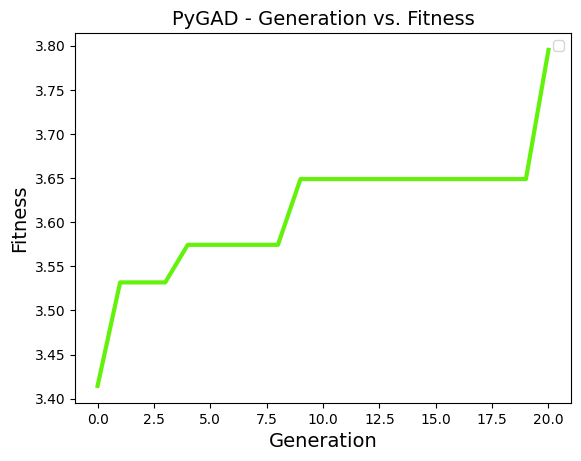

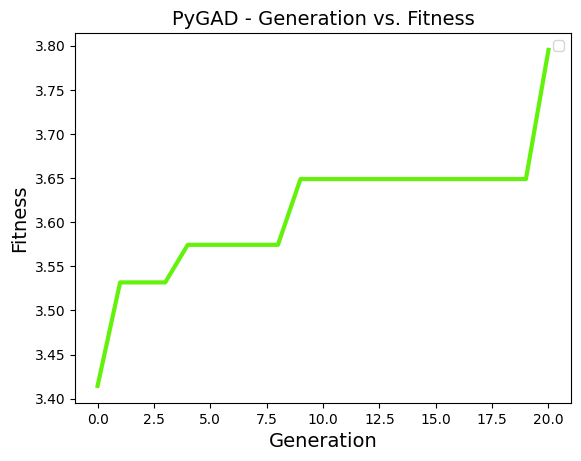

In [21]:
ga_instance.plot_fitness()

In [28]:
best_trajectory, collisions = simulation(int(solution[0]), int(solution[1]), int(solution[2]))

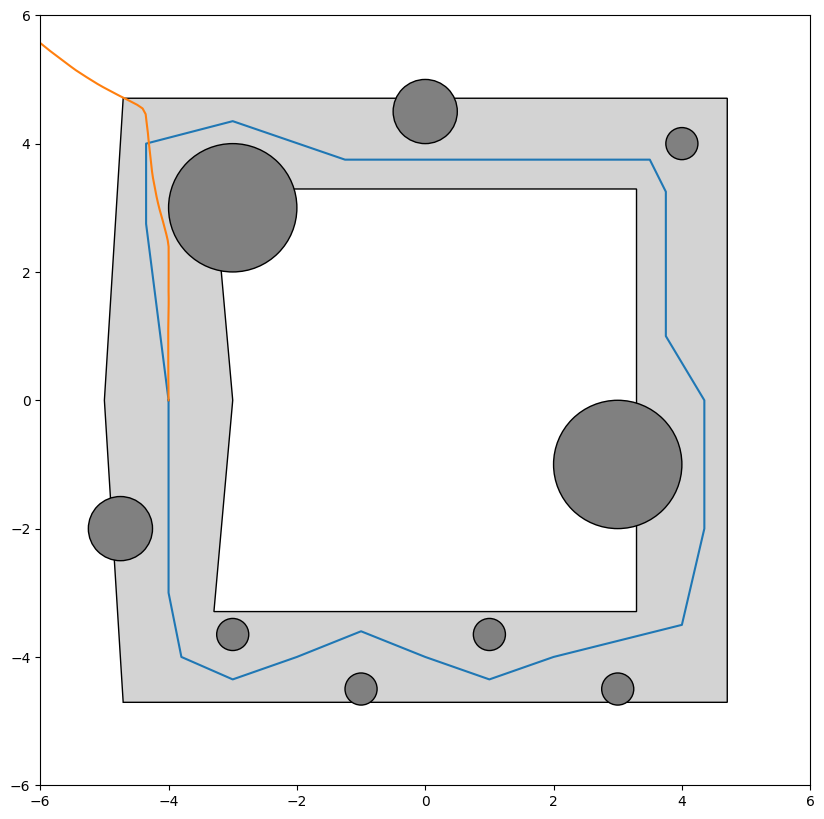

In [29]:
visualizer = TrackVisualizer(track_config)
plt.plot(x_opt, y_opt)
plt.plot(best_trajectory[:,0], best_trajectory[:, 1])